<a href="https://colab.research.google.com/github/ksb25395/CAP6779/blob/master/Distant_supervised_pretraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from gensim.models import KeyedVectors
EMBEDDING_FILE = '/content/gdrive/My Drive/Colab Notebooks/datasets/Google/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# imports 
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup

In [0]:
cols = ['sentiment','id','date','query_string','user','text']
df_train=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/datasets/distant_supervision_data/training.1600000.processed.noemoticon.csv', usecols = [0,5],names=cols, encoding='latin-1')
df_train.head()

In [0]:
df_train["sentiment"] = df_train["sentiment"].replace(4, 1)

In [0]:
# drop rows with retweet text 
df_train.drop(df_train[df_train.text.str.contains(' RT ')].index, inplace=True)

In [0]:
clean_tweets = []
#Strips emojis
def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :'),:D, : D, =)
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))|:\s?D | =\)', '', tweet)
    # Sad -- :-(, : (, :(, ):, )-: , :p
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)|:p', '', tweet)
    return tweet

In [0]:
#clean data
url = re.compile(r"(?:(http[s]?://\S+)|((//)?(\w+\.)?\w+\.\w+/\S+))")
user_mention = re.compile(r"(?:(?<!\w)@\w+\b)")
number = re.compile(r"(?:\b\d+\b)")
repeated_char = '([a-zA-Z])\\1+'
length_repeated_char = '\\1\\1'

def clean(raw):
  #convert HTML encoding to text
  new_row = BeautifulSoup(raw, 'html.parser').get_text()
  
  #Change all text to lower case
  new_row = new_row.lower()
  
  #Replaces any url with class URL
  new_row = re.sub(url, '', new_row)
  
  #replace any @username with class USERNAME
  new_row = re.sub(user_mention, '', new_row)
  
  #Strips repeated chars
  new_row = re.sub(repeated_char, length_repeated_char, new_row)
  
  #Replaces #hashtag with hashtag
  new_row = re.sub(r'#(\S+)', r' \1 ', new_row)
  
  #Remove numbers
  new_row = re.sub(number, '', new_row)
  
  #decode text with 'utf-8-sig'
  try:
    temp_row = new_row.decode("utf-8-sig").replace(u"\ufffd", "?")     
  except:
    temp_row = new_row
  
  #Removes emojis
  new_row = handle_emojis(temp_row);
  
  return new_row

In [0]:
df_train["clean_text"] = df_train["text"].apply(lambda x : clean(x))

In [0]:
df_train.head()

In [0]:
import nltk
import spacy
import string
# preprocessing methods
# Removal of URLs
def remove_urls(text):
  url_pattern = re.compile(r'https?://\S+|www\.\S+')
  return url_pattern.sub(r'', text)

# Remove @ mentions
def remove_mentions(text):
  text = re.sub(r"(?:\@|https?\://)\S+", "", text)
  return text

# strip links
def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

# strip entities
def strip_all_entities(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

# convert emojis
!pip install emot
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
def convert_emoticons(text):
  for emot in EMOTICONS:
    re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
  return text

# convert emoji to word
!pip install emoji
import emoji
def convert_emojis(text):
    return emoji.demojize(text)

# expand contractions
!pip install -q contractions
import contractions
def expand_contractions(text):
  return contractions.fix(text)

# remove punctuations
PUNCT = string.punctuation
def remove_punctuation(text):
  return text.translate(str.maketrans('', '', PUNCT))

# remove stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
  return " ".join([word for word in str(text).split() if word not in STOPWORDS])

# remove frequent words
def remove_freqwords(text, FREQ_WORDS):
  return " ".join([word for word in str(text).split() if word not in FREQ_WORDS])

# remove rare words
def remove_rarewords(text, RAREWORDS):
    """custom function to remove the rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

# lemmatize words
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

# spelling correction

In [0]:
def preprocess(df):
  # Lower casing
  df["text"] = df["text"].str.lower()
  df.head()
  # remove urls
  df["text"] = df["text"].apply(lambda x : remove_urls(x))
  # remove mentions
  df["text"] = df["text"].apply(lambda x: remove_mentions(x))
  # strip links
  df["text"] = df["text"].apply(lambda x: strip_links(x))
  # strip all entities
  df["text"] = df["text"].apply(lambda x: strip_all_entities(x))
  # convert all emoticons
  df["text"] = df["text"].apply(lambda x : convert_emoticons(x))
  # convert all emojis
  df["text"] = df["text"].apply(lambda x : convert_emojis(x))
  # expand all contractions
  df["text"] = df["text"].apply(lambda x : expand_contractions(x))
  # remove all punctuations
  df["text"] = df["text"].apply(lambda x : remove_punctuation(x))
  # remove all stopwords
  df["text"] = df["text"].apply(lambda x : remove_stopwords(x))
  # remove frequent words
  from collections import Counter
  cnt = Counter()
  for text in df["text"].values:
    for word in text.split():
      cnt[word] += 1
  FREQ_WORDS = set([word for (word, count) in cnt.most_common(10)])
  df["text"] = df["text"].apply(lambda x : remove_freqwords(x, FREQ_WORDS))
  # remove rare words
  n_rare_words = 10
  RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
  df["text"] = df["text"].apply(lambda text: remove_rarewords(text, RAREWORDS))
  # lemmatize words
  df["text"] = df["text"].apply(lambda text: lemmatize_words(text))
  # spelling correction
  return df

In [0]:
semeval_df=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/datasets/Semeval-2017-4A-English/SemEval2017-task4-dev.subtask-A.english.INPUT.txt', sep="\t", header=None)
semeval_df = semeval_df.drop(columns=3)
semeval_df.columns = ['id', 'sentiment', 'text']

In [0]:
semeval_df = preprocess(semeval_df)
semeval_df.head()

In [0]:
df_new = df_train.sample(n=250000, random_state = 1)

In [0]:
train_set = set()
for tweet in df_new["clean_text"]:
  for word in tweet.split():
    train_set.add(word)
semeval_set = set()
for tweet in semeval_df["text"]:
  for word in tweet.split():
    semeval_set.add(word)

In [0]:
common_words = list(train_set & semeval_set) 
len(common_words)

In [0]:
len(train_set) + len(semeval_set) - len(common_words)

In [0]:
len(semeval_set)

We can see that out of 18610 unique tokens in semeval dataset, we have 10560 unique tokens present in the distant supervised tweet dataset.

In [0]:
# Tokenizer illustration example
from keras.preprocessing.text import Tokenizer
# define 5 documents
t  = Tokenizer(oov_token='oov')
fit_text = ["The earth is an awesome place live"]
t.fit_on_texts(fit_text)

#fit_on_texts fits on sentences when list of sentences is passed to fit_on_texts() function. 
#ie - fit_on_texts( [ sent1, sent2, sent3,....sentN ] )

#Similarly, list of sentences/single sentence in a list must be passed into texts_to_sequences.
test_text1 = "The earth is an great place live"
test_text2 = "The is my program"
sequences = t.texts_to_sequences([test_text1, test_text2])

print('sequences : ',sequences,'\n')

print('word_index : ',t.word_index)
#texts_to_sequences() returns list of list. ie - [ [] ]

In [0]:
ds_texts = df_new["text"]

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'', lower=True)
tokenizer.fit_on_texts(ds_texts)
sequences = tokenizer.texts_to_sequences(ds_texts)
word_index = tokenizer.word_index
print(len(word_index))

In [0]:
X_train = pad_sequences(sequences)
y_train = to_categorical(list(df_new["sentiment"]))

In [0]:
EMBED_DIM = 300
vocab_size = len(word_index) + 1
embedding_matrix = np.random.normal(0,np.sqrt(0.25),[vocab_size, EMBED_DIM])

In [0]:
count = []
for word, i in word_index.items():
    if i >= vocab_size:
        continue
    try:
        embedding_vec = word2vec[word]
        embedding_matrix[i] = embedding_vec
    except KeyError:
        count.append(word)
        embedding_matrix[i] = np.random.normal(0,np.sqrt(0.25),EMBED_DIM)

In [27]:
len(count)

142586

In [0]:
from keras.layers import Input
from keras.layers import Flatten
from keras.layers import Dense
from keras.models import Model
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Embedding

In [0]:
from keras.layers import Embedding
embedding_layer = Embedding(vocab_size,
                            EMBED_DIM,
                            weights=[embedding_matrix],
                            trainable=True)
seq_len = X_train.shape[1]
from keras.layers import Input
from keras.layers import Flatten
from keras.layers import Dense
from keras.models import Model
from keras.layers import LSTM
from keras.layers import Dropout
inputs = Input(shape=(seq_len,))
embeddings = embedding_layer(inputs)
# flattened = Flatten()(embeddings)
lstm = LSTM(300, dropout=0.5)(embeddings)
dense0 = Dense(128, activation="relu")(lstm)
# dropout0 = Dropout()(dense0)
dense1 = Dense(64, activation="relu")(dense0)
dropout1 = Dropout(rate=0.25)(dense1)
dense2 = Dense(32, activation="relu")(dropout1)
dropout2 = Dropout(rate=0.25)(dense2)
dense3 = Dense(16, activation="relu")(dropout2)
output = Dense(y_train.shape[1], activation='softmax')(dense3)
model = Model(inputs, output)

In [0]:
from keras.optimizers import Adam
adam = Adam(lr=1e-3)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['acc'])
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [0]:
model.fit(X_train, y_train, batch_size=1000, epochs=5, verbose=1, shuffle=True, validation_split=0.1, callbacks=[es])

Train on 225000 samples, validate on 25000 samples
Epoch 1/5
225000/225000 [==============================] - 1580s 7ms/step - loss: 0.5219 - acc: 0.7396 - val_loss: 0.4491 - val_acc: 0.7970
Epoch 2/5
225000/225000 [==============================] - 1548s 7ms/step - loss: 0.4265 - acc: 0.8053 - val_loss: 0.4258 - val_acc: 0.8064
Epoch 3/5
225000/225000 [==============================] - 1532s 7ms/step - loss: 0.3767 - acc: 0.8329 - val_loss: 0.4244 - val_acc: 0.8060
Epoch 4/5
225000/225000 [==============================] - 1542s 7ms/step - loss: 0.3266 - acc: 0.8593 - val_loss: 0.4327 - val_acc: 0.8020
Epoch 5/5
 87000/225000 [==========>...................] - ETA: 15:24 - loss: 0.2700 - acc: 0.8889

KeyboardInterrupt: ignored

In [0]:
model.save('/content/gdrive/My Drive/Colab Notebooks/distant_tweets_pretrained.h5')

In [1]:
from keras.models import load_model
model = load_model('/content/gdrive/My Drive/Colab Notebooks/distant_tweets_pretrained.h5')
model.summary()

Using TensorFlow backend.


OSError: ignored

In [0]:
model.layers.pop()
model.layers.pop()
model.layers.pop()
model.layers.pop()
model.layers.pop()
model.layers.pop()
model.layers.pop()
model.summary()

In [0]:
semeval_df.sentiment = semeval_df.sentiment.astype('category')
semeval_df["sentiment"] = semeval_df["sentiment"].cat.codes
semeval_df.head()

In [78]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in split.split(semeval_df, semeval_df["sentiment"]):
    train_set = semeval_df.loc[train_idx]
    test_set = semeval_df.loc[test_idx]

print(train_set["sentiment"].value_counts())
print(test_set["sentiment"].value_counts())

1    8273
2    5647
0    2585
Name: sentiment, dtype: int64
1    2069
2    1412
0     646
Name: sentiment, dtype: int64


In [0]:
semeval_train_texts = train_set["text"]
semeval_test_texts = test_set["text"]

In [0]:
semeval_train_sequences = tokenizer.texts_to_sequences(semeval_train_texts)
X_semeval_train = pad_sequences(semeval_train_sequences, X_train.shape[1])
y_semeval_train = to_categorical(list(train_set["sentiment"]))

In [0]:
semeval_test_sequences = tokenizer.texts_to_sequences(semeval_test_texts)
X_semeval_test = pad_sequences(semeval_test_sequences, X_train.shape[1])
y_semeval_test = to_categorical(list(test_set["sentiment"]))

In [82]:
X_semeval_train.shape

(16505, 118)

In [0]:
dense0 = Dense(128, activation='relu')(model.layers[-1].output)
dropout0 = Dropout(rate=0.2)(dense0)
dense1 = Dense(64, activation='relu')(dropout0)
dropout1 = Dropout(rate=0.2)(dense1)
dense2 = Dense(32, activation="relu")(dropout1)
dropout2 = Dropout(rate=0.2)(dense2)
dense3 = Dense(16, activation="relu")(dropout2)
output = Dense(y_semeval_train.shape[1], activation='softmax')(dense3)
# from keras.layers import BatchNormalization
# dense0 = Dense(128, activation='relu')(model.layers[-1].output)
# batchn0 = BatchNormalization()(dense0)
# dropout0 = Dropout(rate=0.25)(batchn0)
# dense1 = Dense(64, activation='relu')(dropout0)
# batchn1 = BatchNormalization()(dense1)
# dropout1 = Dropout(rate=0.25)(batchn1)
# dense2 = Dense(32, activation="relu")(batchn1)
# batchn2 = BatchNormalization()(dense2)
# dropout2 = Dropout(rate=0.25)(batchn2)
# dense3 = Dense(16, activation="relu")(dropout2)
# output = Dense(y_semeval_train.shape[1], activation='softmax')(dense3)

In [84]:
seq_len_semeval = X_semeval_train.shape[1]
new_model = Model(input=model.input, output=[output])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`
  


In [85]:
new_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 118)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 118, 300)          55440300  
_________________________________________________________________
lstm_2 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_16 (Dense)             (None, 128)               38528     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0   

In [0]:
# Make embeddings non-trainable
new_model.layers[1].trainable = False
# new_model.layers[2].trainable = False

In [0]:
from keras.optimizers import Adam, Nadam, Adadelta, SGD, RMSprop
# Adadelta performs poorly
# Adam performs better than Nadam
# SGD fares poorly
# Default adam lr = 2e-3
opt = Adam(lr=1e-3)

new_model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

from keras.callbacks import LearningRateScheduler
import math
# learning rate schedule
def step_decay(epoch):
	initial_lrate = 0.01
	drop = 0.1
	epochs_drop = 5.00
	lrate = initial_lrate * math.pow(drop, ((1+epoch)/epochs_drop))
	return min(1e-4, lrate)

# learning schedule callback
lrate = LearningRateScheduler(step_decay)
# from keras.callbacks import EarlyStopping
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [100]:
print(X_semeval_train.shape, y_semeval_train.shape)

(16505, 118) (16505, 3)


In [104]:
history = new_model.fit(X_semeval_train, y_semeval_train, batch_size=500, epochs=40, verbose=1, shuffle=True, validation_split=0.2)

Train on 13204 samples, validate on 3301 samples
Epoch 1/40
13204/13204 [==============================] - 84s 6ms/step - loss: 0.4879 - acc: 0.7946 - val_loss: 0.9133 - val_acc: 0.6331
Epoch 2/40
13204/13204 [==============================] - 84s 6ms/step - loss: 0.4807 - acc: 0.7959 - val_loss: 0.9458 - val_acc: 0.6304
Epoch 3/40
13204/13204 [==============================] - 84s 6ms/step - loss: 0.4727 - acc: 0.7999 - val_loss: 0.9959 - val_acc: 0.6265
Epoch 4/40
13204/13204 [==============================] - 84s 6ms/step - loss: 0.4495 - acc: 0.8149 - val_loss: 0.9877 - val_acc: 0.6347
Epoch 5/40
13204/13204 [==============================] - 85s 6ms/step - loss: 0.4375 - acc: 0.8163 - val_loss: 1.0082 - val_acc: 0.6259
Epoch 6/40
13204/13204 [==============================] - 84s 6ms/step - loss: 0.4387 - acc: 0.8126 - val_loss: 1.0110 - val_acc: 0.6347
Epoch 7/40
13204/13204 [==============================] - 84s 6ms/step - loss: 0.4258 - acc: 0.8187 - val_loss: 1.0333 - val_acc:

KeyboardInterrupt: ignored

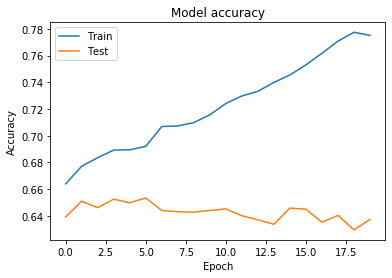

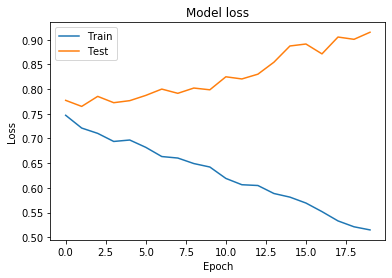

In [105]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [102]:
new_model.evaluate(X_semeval_test, y_semeval_test)

4127/4127 [==============================] - 15s 4ms/step


[0.8829889446244218, 0.6338744851847898]

In [103]:
y_pred = new_model.predict(X_semeval_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_semeval_test, axis=1)
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro')

0.596319214897923

Results of Ablation tests:
1.   Embedding frozen but LSTM trainable : 
2.   Embedding trainable but LSTM frozen
3.   Embedding and LSTM both trainable : 0.6003421



In [0]:
from keras.models import load_model
model = load_model('/content/gdrive/My Drive/Colab Notebooks/distant_tweets_pretrained.h5')
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 49)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 49, 300)           33786000  
_________________________________________________________________
lstm_4 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_26 (Dense)             (None, 128)               38528     
_________________________________________________________________
dense_27 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 32)                2080

In [0]:
model.layers.pop()
model.layers.pop()
model.layers.pop()
model.layers.pop()
model.layers.pop()
model.layers.pop()
model.layers.pop()
model.layers.pop()
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 38)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 38, 300)           33754500  
_________________________________________________________________
lstm_3 (LSTM)                (None, 300)               721200    
Total params: 34,501,766
Trainable params: 34,501,766
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [0]:
dense0 = Dense(128, activation='softmax')(model.layers[-1].output)
dense1 = Dense(64, activation='softmax')(dense0)
dropout1 = Dropout(rate=0.25)(dense1)
dense2 = Dense(32, activation="relu")(dropout1)
dropout2 = Dropout(rate=0.25)(dense2)
dense3 = Dense(16, activation="relu")(dropout2)
output = Dense(y_semeval_train.shape[1], activation='softmax')(dense3)

Freeze embedding but LSTM trainable


In [0]:
# model.layers[1].trainable = False

In [0]:
new_model = Model(input=model.input, output=[output])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`
  """Entry point for launching an IPython kernel.


In [0]:
new_model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 38)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 38, 300)           33754500  
_________________________________________________________________
lstm_3 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_35 (Dense)             (None, 128)               38528     
_________________________________________________________________
dense_36 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_17 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 32)                2080

In [0]:
from keras.optimizers import Adam
adam = Adam(lr=1e-3)

new_model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['acc'])

In [74]:
new_model.fit(X_semeval_train, y_semeval_train, batch_size=1000, epochs=20, verbose=1, shuffle=True, validation_split=0.2)

Train on 13204 samples, validate on 3301 samples
Epoch 1/20
13204/13204 [==============================] - 83s 6ms/step - loss: 1.0336 - acc: 0.4716 - val_loss: 0.9563 - val_acc: 0.4838
Epoch 2/20
 8000/13204 [=================>............] - ETA: 28s - loss: 0.9518 - acc: 0.5047

KeyboardInterrupt: ignored

In [0]:
new_model.evaluate(X_semeval_test, y_semeval_test)

4127/4127 [==============================] - 2s 462us/step


[0.872562335670962, 0.6290283499776176]

In [0]:
y_pred = new_model.predict(X_semeval_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_semeval_test, axis=1)
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro')

0.5830646250813123